# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

***Vamos a importar las librerias que vamos a manejar***

In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
from nltk.tokenize import RegexpTokenizer
import pandas_profiling as pdp
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import es_core_news_md
import es_core_news_sm
import es_core_news_md
import re
from unicodedata import normalize
import gc
gc.enable()
from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
sns.set()

**Vamos a cargar los dataset para nuestro estudio**

In [3]:
dataset_dev = pd.read_json('dataset_es_dev.json', lines= True)
dataset_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [4]:
dataset_test = pd.read_json('dataset_es_test.json', lines= True)
dataset_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [5]:
dataset_train = pd.read_json('dataset_es_train.json', lines= True)
dataset_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


**Revisemos la cantidad de información de nuestros dataset**

In [6]:
dataset_dev.shape

(5000, 8)

In [7]:
dataset_test.shape

(5000, 8)

In [8]:
dataset_train.shape

(200000, 8)

**Con el fin simplificar el procesamiento  de nuestros dataser vamos a unir los datos y posteriormente separarlos para su anáisis**



In [9]:
data=pd.concat([dataset_dev, dataset_test, dataset_train], axis=0)
data.shape

(210000, 8)

**Revisemos detalladamente nuestro dataset**

In [10]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,210000.0,3.0,1.414217,1.0,2.0,3.0,4.0,5.0


In [12]:
data.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.4+ MB


In [14]:
data.isnull().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

**Cantidad de estrellas por critica**

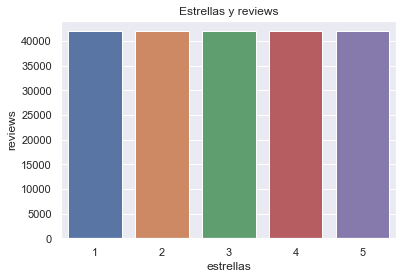

In [15]:
sns.countplot(data=data,x='stars',orient="h")
plt.title("Estrellas y reviews")
plt.xlabel("estrellas")
plt.ylabel("reviews")
plt.show()

**Revisemos la distribucion en porcentaje de las estrellas**

<function matplotlib.pyplot.show(close=None, block=None)>

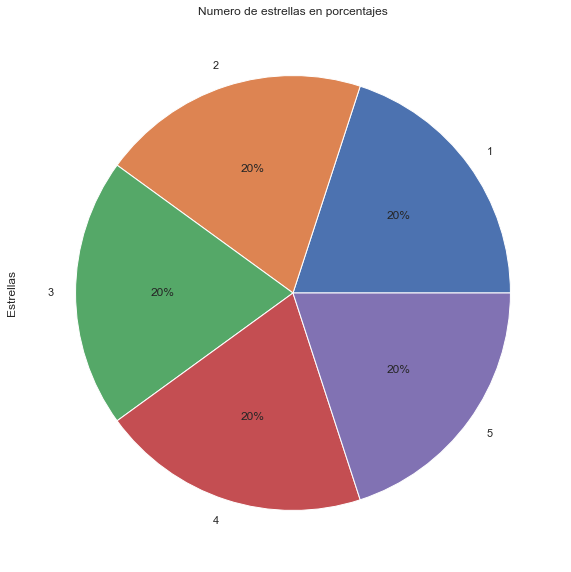

In [16]:
plt.figure(figsize=(10,10))
data.stars.value_counts().plot(kind="pie", autopct='%1.0f%%')
plt.ylabel("Estrellas")

plt.title("Numero de estrellas en porcentajes")
plt.show

**Promedio de estrellas por producto**

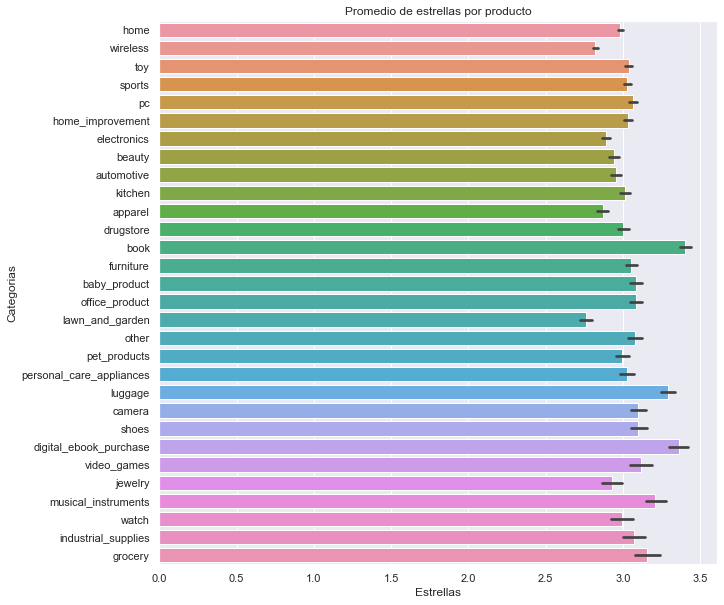

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x='stars', y='product_category' ,
            data=data,
            order = data.product_category.value_counts().index)

plt.ylabel("Categorias")
plt.xlabel("Estrellas")
plt.title("Promedio de estrellas por producto")
plt.show()

**Analicemos la cantidad segun producto**

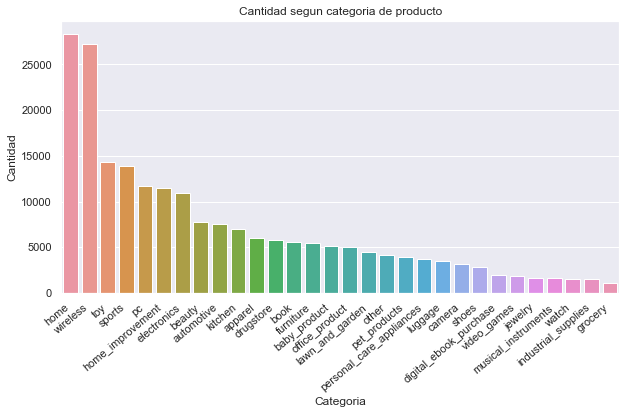

In [18]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data = data, x = "product_category",
                   order = data.product_category.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.ylabel("Cantidad")
plt.xlabel("Categoria")
plt.title("Cantidad segun categoria de producto")
plt.show()

**Revisemos la participacion de producto segun su porcentaje**

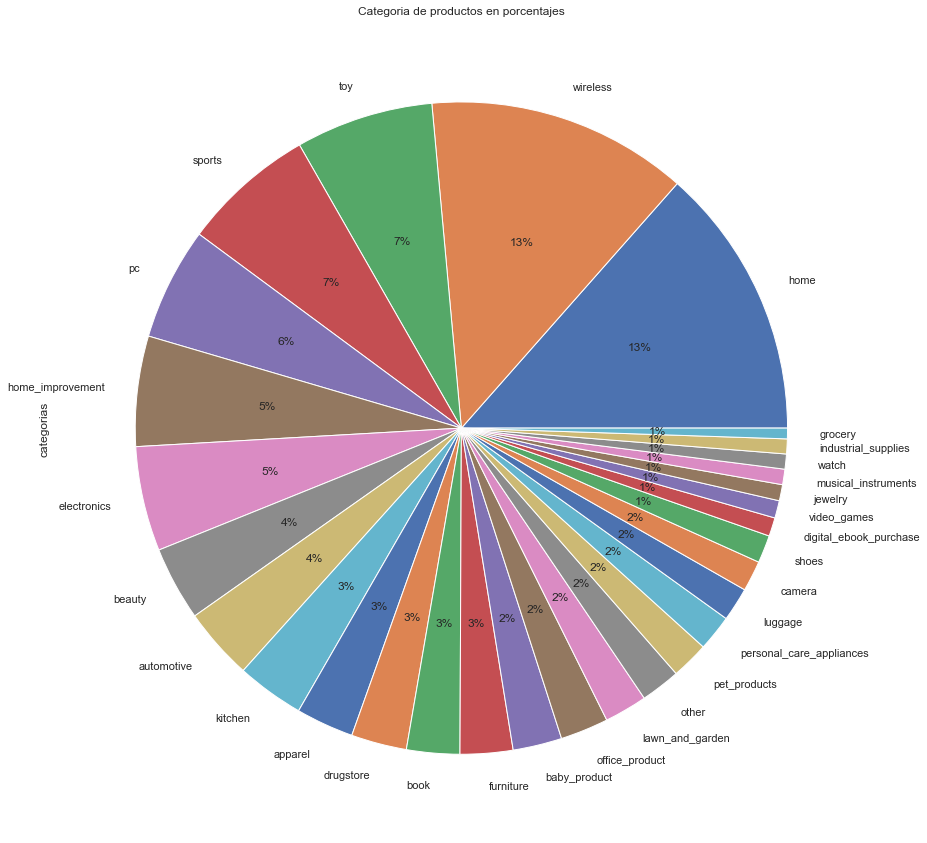

In [19]:
plt.figure(figsize=(22,15))
data.product_category.value_counts().plot(kind="pie", autopct='%1.0f%%')
plt.ylabel("categorias")

plt.title("Categoria de productos en porcentajes")
plt.show()

In [20]:
data.language.unique()

array(['es'], dtype=object)

In [21]:
len(data.reviewer_id.unique())

187140

**Analiis usuario individual**

In [22]:
per_user=data["reviewer_id"].value_counts()
per_user

reviewer_es_0431022    7
reviewer_es_0588051    7
reviewer_es_0437514    7
reviewer_es_0424425    6
reviewer_es_0035822    6
                      ..
reviewer_es_0007832    1
reviewer_es_0375673    1
reviewer_es_0849774    1
reviewer_es_0463022    1
reviewer_es_0270058    1
Name: reviewer_id, Length: 187140, dtype: int64

In [23]:
user_unique=data[data.reviewer_id == "reviewer_es_0588051" ]
user_unique

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
82233,es_0673224,product_es_0616815,reviewer_es_0588051,3,"Generó super fino, se notan mucho las costuras...",No me la quede.,es,sports
84353,es_0188523,product_es_0145354,reviewer_es_0588051,3,"Me gusto mucho el tacto , pero el género hacía...",Calidad mediocre.,es,sports
87843,es_0254703,product_es_0420214,reviewer_es_0588051,3,"La idea y el producto yo se ve de calidad , pe...",Buena cosa,es,sports
113208,es_0535895,product_es_0481160,reviewer_es_0588051,3,"Calidad muy buena, pero las tallas no están mu...",No me fue bien la talla,es,pet_products
117067,es_0846764,product_es_0651420,reviewer_es_0588051,3,"Es un poco recio, y le pica el cuello a mi hij...",Normal,es,sports
131219,es_0999442,product_es_0740672,reviewer_es_0588051,4,"Parecía que quedaban bien los cristales, pero ...",Bastante bien,es,kitchen
154756,es_0051525,product_es_0258519,reviewer_es_0588051,4,"Va muy bien , cómodo y discreto",Fenomenal,es,apparel


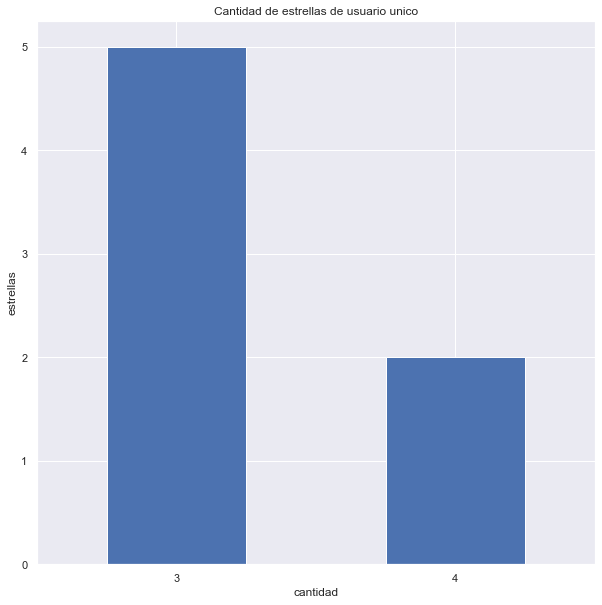

In [24]:
plt.figure(figsize=(10,10))
user_unique.stars.value_counts().plot(kind="bar")
plt.ylabel("estrellas")
plt.xlabel("cantidad")
plt.xticks(rotation=0)
plt.title("Cantidad de estrellas de usuario unico")
plt.show()

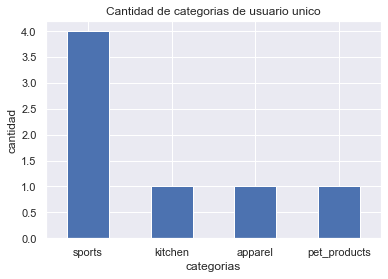

In [25]:
user_unique.product_category.value_counts().plot(kind="bar")
plt.ylabel("cantidad")
plt.xlabel("categorias")
plt.xticks(rotation=0)
plt.title("Cantidad de categorias de usuario unico")
plt.show()

In [26]:
list(user_unique['review_body'])[:5]

['Generó super fino, se notan mucho las costuras y no le fue bien, pero es bonita.',
 'Me gusto mucho el tacto , pero el género hacía bolas en una semana de uso.',
 'La idea y el producto yo se ve de calidad , pero en el envío me llego mal, la tapa no encajaba y así no se puede usar, porque una vez abierto se seca el resto .',
 'Calidad muy buena, pero las tallas no están muy bien . De una a otra es mucha la diferencia.',
 'Es un poco recio, y le pica el cuello a mi hijo ., no me lo quede.']

# Procesamiento de datos

**Columnas de un solo valor**

In [27]:
for i in range(data.shape[1]):
    print(i,len(pd.unique(data.iloc[:,i])))

0 210000
1 156458
2 187140
3 5
4 208127
5 117156
6 1
7 30


**Columnas con pocos valores**

In [28]:
for i in range(data.shape[1]):
    num=len(pd.unique(data.iloc[:,i]))
    porcentaje=float(num)/data.shape[0]*100
    print("%d, %d, %.1f%%"%(i,num,porcentaje))

0, 210000, 100.0%
1, 156458, 74.5%
2, 187140, 89.1%
3, 5, 0.0%
4, 208127, 99.1%
5, 117156, 55.8%
6, 1, 0.0%
7, 30, 0.0%


**Datos duplicados**

In [29]:
duplicado = data.duplicated()
print(duplicado.any())
print(data[duplicado])

False
Empty DataFrame
Columns: [review_id, product_id, reviewer_id, stars, review_body, review_title, language, product_category]
Index: []


**Eliminaciòn de columnas sin valor**

In [30]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [31]:
data=data.drop(["review_id","product_id","reviewer_id","language"],axis=1)

In [32]:
data.head()

,stars,review_body,review_title,product_category
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty


# NLP - Preparacion NLP

In [33]:
nlp = es_core_news_md.load()

**Preparacion de Stopwords**

In [34]:
stopwords_spacy = list(STOP_WORDS)
print(stopwords_spacy)
len(stopwords_spacy)

['intentas', 'esta', 'ninguno', 'aquellas', 'lo', 'hacemos', 'intentais', 'uno', 'diferente', 'ésos', 'eso', 'alguna', 'las', 'tal', 'he', 'tarde', 'cerca', 'realizó', 'pueda', 'nuestros', 'podrian', 'cuales', 'cada', 'detras', 'varias', 'podrias', 'quizas', 'cualquier', 'mí', 'buen', 'llevar', 'indicó', 'ante', 'pasado', 'poner', 'demás', 'cuanto', 'la', 'solas', 'creo', 'acuerdo', 'últimos', 'tuyo', 'embargo', 'siempre', 'pocos', 'buenas', 'sea', 'saber', 'encima', 'anterior', 'tampoco', 'actualmente', 'verdadera', 'vuestro', 'soy', 'menudo', 'mediante', 'aquéllas', 'raras', 'ninguna', 'toda', 'dicho', 'tuyos', 'sola', 'todos', 'todavía', 'nada', 'hemos', 'salvo', 'pues', 'podrán', 'dejó', 'debido', 'vuestra', 'cuando', 'primera', 'aseguró', 'sí', 'veces', 'hacer', 'ningunas', 'queremos', 'habrá', 'fuera', 'quizás', 'hizo', 'mia', 'adelante', 'esas', 'podrían', 'buena', 'se', 'misma', 'estamos', 'haces', 'despacio', 'sé', 'estas', 'estais', 'sólo', 'usan', 'informo', 'comentó', 'cons

551

In [35]:
nlp = es_core_news_md.load() 
nlp.max_length = 2000000

###  1. Haz todas las transformaciones de datos que consideres necesarias.

### *Transformaciones de datos necesarias.*

A) Eliminacion de todas las tildes,salvo la Ñ. Objetivo: reducir errores ortograficos.

B) Realizar una tokenizacion eliminando todo aquello que no sean letras.. Objetivo: Eliminacion de signos o caracteres especiales.

C) Llevar todas las palabras a minuscula. Objetivo: Reducir el trabajo al analizar el texto con palabras que significan lo mismo pero algunas utilizan mayusculas y otras no segun el contexto.

D) Utilizacion de stopwords. Objetivo: eliminar las palabras con poco valor para el analisis.

E) Spellcheck. Objetivo: aplicar correccion ortografica en todo el texto.

F) Spacy. Objetivo: Realizar una tokenizacion.

G) Lemmatizacion. Objetivo: Trabajar con los lemma de cada palabra.

**Eliminacion "review_title"**

In [36]:
revs=[]
for i in range(data.shape[0]):
    review = data.iloc[i].review_title 
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I
    )
    review=normalize( 'NFC', review)
    revs.append(review)
data["New_R_title"]=pd.Series(revs)

In [37]:
data["New_R_title"]=pd.Series(revs)

**Eliminacion "review_body"**

In [38]:
revs=[]

for i in range(data.shape[0]):
    review = data.iloc[i].review_body
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I
    )
    review=normalize( 'NFC', review)
    revs.append(review)

In [39]:
data["New_R_body"]=pd.Series(revs)

**Spellchecker**

In [40]:
spell = SpellChecker(language='es',distance=1)

**Tokenizacion, StopWords, Spellcheck y Lemmatizacion en:**

***review_title***

In [41]:
def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

In [42]:
%%time

regexp=RegexpTokenizer(r"\w+")
tokeandstp=[]
data['New_R_title_Lemm'] = ''

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_title
    review = regexp.tokenize(review)
    review = [word.lower() for word in review if word.lower() not in STOP_WORDS]
    review = spell_check(review)
    review = nlp(review) 
    review = [word.lemma_ for word in review]
    data['New_R_title_Lemm'].iloc[i] = ' '.join(review)

C:\Users\Claud\miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 31min 9s


In [43]:
data.drop("New_R_title",axis=1,inplace=True)

**Tokenizacion, StopWords, Spellcheck y Lemmatizacion en:**

***review_body***

In [44]:
def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

In [45]:
%%time

tokeandstp=[]
regexp=RegexpTokenizer(r"\w+")
data['New_R_body_Lemm'] = ''

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_body
    review = regexp.tokenize(review) 
    review = [word.lower() for word in review if word.lower() not in STOP_WORDS]
    review = spell_check(review)
    review = nlp(review)
    review = [word.lemma_ for word in review]
    data['New_R_body_Lemm'].iloc[i] = ' '.join(review)

Wall time: 46min 37s


In [46]:
data.drop("New_R_body",axis=1,inplace=True)

**Trabajar con Adjetivos**

In [47]:
data.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
New_R_title_Lemm    0
New_R_body_Lemm     0
dtype: int64

**Debemos eliminar los NA antes de proseguir.**

In [48]:
data = data.dropna(subset=['New_R_title_Lemm',"New_R_body_Lemm"])

**Review_title Adj**

In [49]:
%%time

adjetivos = []

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_title_Lemm
    review = nlp(review)
    review = [word for word in review if word.pos_ == "ADJ"]
    adjetivos.append(review)

Wall time: 21min 12s


In [50]:
data["New_R_title_Lemm_ADJ"] = pd.Series(adjetivos)

**Review_Body Adj** 

In [51]:
%%time


adjetivos = []

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_body_Lemm
    review = nlp(review)
    review = [word for word in review if word.pos_ == "ADJ"]
    adjetivos.append(review)

Wall time: 23min 58s


In [52]:
data["New_R_body_Lemm_ADJ"] = pd.Series(adjetivos)

**Analisis Adjetivos**

***Review_title***

In [53]:
dfstar1 = data[data.stars == 1]
dfstar2 = data[data.stars == 2]
dfstar3 = data[data.stars == 3]
dfstar4 = data[data.stars == 4]
dfstar5 = data[data.stars == 5]

**1 Estrella**

In [54]:
dfstar1 = dfstar1.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar1['New_R_title_Lemm_ADJ']=dfstar1['New_R_title_Lemm_ADJ'].apply(str)

In [55]:
star1 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar1.shape[0]):
    x = dfstar1.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star1.append(x) 

In [56]:
words_star1=[line for line in star1 for line in set(line)]
words_star1 = Counter(words_star1)
words_star1 = words_star1.most_common(20)
words_star1=pd.DataFrame(words_star1,columns = ['Words', 'Frequency'])
words_star1.head(10)

,Words,Frequency
0,malo,2301
1,perfecto,552
2,bonito,534
3,pequeño,525
4,recomendable,516
5,defectuoso,383
6,fatal,340
7,correcto,278
8,decepcionante,248
9,util,226


**2 Estrellas**

In [57]:
dfstar2.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ
1000,2,Me han enviado algo completamente diferente. E...,Muy mal,home,,enviar completamente a diferenciar foto y medi...,[],[]
1001,2,En menos de 2 semanas de uso una de las mangas...,Baja calidad de producto,kitchen,bajo calidad producto,2 semana mangar rotar y po enganchar sno costu...,[],[]
1002,2,"Hicimos el pedido de la barrera, hasta ahí tod...",Decepcionados con el embalaje y el estado del ...,baby_product,decepcionar embalaje y ser articular,hacer pedir barrera llegar imagenes caja fatal...,[],"[fatal, mayuscula, etiquetar, completo, amazon..."
1003,2,Queda grande no es una S pero se puede arregla...,Mas o menos,apparel,o,quedo grande segundo arreglar gracia,[],"[grande, segundo]"
1004,2,En 5 días de uso se ha roto el pulsador de pue...,Poca calidad,home_improvement,calidad,5 rotar pulsador poner marchar y correar inten...,[],[]


In [58]:
dfstar2 = dfstar2.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar2['New_R_title_Lemm_ADJ']=dfstar2['New_R_title_Lemm_ADJ'].apply(str)

In [59]:
star2 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar2.shape[0]):
    x = dfstar2.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star2.append(x) 

In [60]:
words_star2=[line for line in star2 for line in set(line)]
words_star2 = Counter(words_star2)
words_star2 = words_star2.most_common(20)
words_star2=pd.DataFrame(words_star2,columns = ['Words', 'Frequency'])
words_star2.head(10)

,Words,Frequency
0,malo,2722
1,pequeño,877
2,defectuoso,423
3,caro,356
4,recomendable,342
5,bonito,338
6,fatal,318
7,decepcionante,315
8,barato,217
9,pesima,209


***3 estrellas***

In [61]:
dfstar3 = dfstar3.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar3['New_R_title_Lemm_ADJ']=dfstar3['New_R_title_Lemm_ADJ'].apply(str)

In [62]:
star3 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar3.shape[0]):
    x = dfstar3.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star3.append(x) 

In [63]:
words_star3=[line for line in star3 for line in set(line)]
words_star3 = Counter(words_star3)
words_star3 = words_star3.most_common(20)
words_star3=pd.DataFrame(words_star3,columns = ['Words', 'Frequency'])
words_star3.head(10)

,Words,Frequency
0,malo,1226
1,pequeño,1176
2,bonito,789
3,correcto,574
4,caro,458
5,aceptable,337
6,mejorable,308
7,grande,299
8,normal,293
9,util,255


**4 Estrellas**

In [64]:
dfstar4 = dfstar4.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar4['New_R_title_Lemm_ADJ']=dfstar4['New_R_title_Lemm_ADJ'].apply(str)

In [65]:
star4 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar4.shape[0]):
    x = dfstar4.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star4.append(x) 

In [66]:
words_star4=[line for line in star4 for line in set(line)]
words_star4 = Counter(words_star4)
words_star4 = words_star4.most_common(20)
words_star4=pd.DataFrame(words_star4,columns = ['Words', 'Frequency'])
words_star4.head(10)

,Words,Frequency
0,bonito,1214
1,correcto,1050
2,perfecto,967
3,pequeño,764
4,util,470
5,aceptable,413
6,recomendable,375
7,genial,306
8,caro,302
9,grande,294


**5 Estrellas**

In [67]:
dfstar5 = dfstar5.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar5['New_R_title_Lemm_ADJ']=dfstar5['New_R_title_Lemm_ADJ'].apply(str)

In [68]:
star5 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar5.shape[0]):
    x = dfstar5.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star5.append(x) 

In [69]:
words_star5=[line for line in star5 for line in set(line)]
words_star5 = Counter(words_star5)
words_star5 = words_star5.most_common(20)
words_star5=pd.DataFrame(words_star5,columns = ['Words', 'Frequency'])
words_star5.head(10)

,Words,Frequency
0,perfecto,2824
1,bonito,1224
2,genial,994
3,correcto,840
4,recomendable,774
5,excelente,763
6,util,597
7,comodo,326
8,pequeño,325
9,ideal,306


## Mejorando la Visualizacion

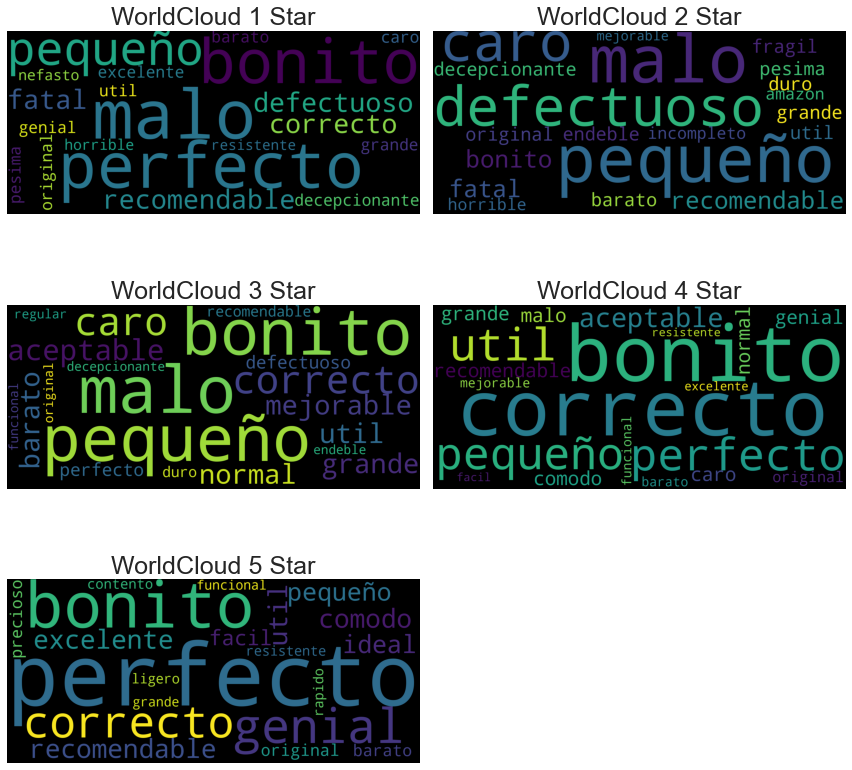

In [70]:
plt.figure(figsize=(12,12))

plt.subplot(321)
estrella1=(" ").join(words_star1["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800 ).generate(estrella1)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 1 Star', fontsize=25)

plt.subplot(322)
estrella2=(" ").join(words_star2["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella2)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 2 Star', fontsize=25)

plt.subplot(323)
estrella3=(" ").join(words_star3["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella3)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 3 Star', fontsize=25)

plt.subplot(324)
estrella4=(" ").join(words_star4["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella4)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 4 Star', fontsize=25)

plt.subplot(325)
estrella5=(" ").join(words_star5["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella5)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 5 Star', fontsize=25)

plt.tight_layout()
plt.show()

**Review_Body**

**1 Estrella**

In [71]:
dfstar1 = dfstar1.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar1['New_R_body_Lemm_ADJ']=dfstar1['New_R_body_Lemm_ADJ'].apply(str)

In [72]:
star1 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar1.shape[0]):
    x = dfstar1.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star1.append(x) 

In [73]:
words_star1=[line for line in star1 for line in set(line)]
words_star1 = Counter(words_star1)
words_star1 = words_star1.most_common(20)
words_star1=pd.DataFrame(words_star1,columns = ['Words', 'Frequency'])
words_star1.head(10)

,Words,Frequency
0,malo,2728
1,pequeño,2154
2,perfecto,1423
3,bonito,1313
4,amazon,1141
5,caro,954
6,grande,879
7,original,782
8,facil,741
9,recomendable,631


**2 Estrellas**

In [74]:
dfstar2 = dfstar2.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar2['New_R_body_Lemm_ADJ']=dfstar2['New_R_body_Lemm_ADJ'].apply(str)

In [75]:
star2 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar2.shape[0]):
    x = dfstar2.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star2.append(x)

In [76]:
words_star2=[line for line in star2 for line in set(line)]
words_star2 = Counter(words_star2)
words_star2 = words_star2.most_common(20)
words_star2=pd.DataFrame(words_star2,columns = ['Words', 'Frequency'])
words_star2.head(10)

,Words,Frequency
0,malo,3187
1,pequeño,2485
2,bonito,1327
3,amazon,1097
4,caro,1024
5,grande,897
6,barato,700
7,original,699
8,perfecto,619
9,plastico,587


**3 Estrellas**

In [77]:
dfstar3 = dfstar3.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar3['New_R_body_Lemm_ADJ']=dfstar3['New_R_body_Lemm_ADJ'].apply(str)

In [78]:
star3 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar3.shape[0]):
    x = dfstar3.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star3.append(x)

In [79]:
words_star3=[line for line in star3 for line in set(line)]
words_star3 = Counter(words_star3)
words_star3 = words_star3.most_common(20)
words_star3=pd.DataFrame(words_star3,columns = ['Words', 'Frequency'])
words_star3.head(10)

,Words,Frequency
0,pequeño,3347
1,bonito,2111
2,malo,1961
3,grande,1382
4,perfecto,1229
5,caro,1200
6,correcto,938
7,facil,842
8,original,807
9,normal,746


**4 Estrellas**

In [80]:
dfstar4 = dfstar4.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar4['New_R_body_Lemm_ADJ']=dfstar4['New_R_body_Lemm_ADJ'].apply(str)

In [81]:
star4 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar4.shape[0]):
    x = dfstar4.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star4.append(x)

In [82]:
words_star4=[line for line in star4 for line in set(line)]
words_star4 = Counter(words_star4)
words_star4 = words_star4.most_common(20)
words_star4=pd.DataFrame(words_star4,columns = ['Words', 'Frequency'])
words_star4.head(10)

,Words,Frequency
0,pequeño,2922
1,perfecto,2570
2,bonito,2450
3,facil,1557
4,grande,1519
5,correcto,1336
6,malo,999
7,genial,971
8,caro,969
9,original,944


**5 Estrellas**

In [83]:
dfstar5 = dfstar5.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar5['New_R_body_Lemm_ADJ']=dfstar5['New_R_body_Lemm_ADJ'].apply(str)

In [84]:
star5 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar5.shape[0]):
    x = dfstar5.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star5.append(x)

In [85]:
words_star5=[line for line in star5 for line in set(line)]
words_star5 = Counter(words_star5)
words_star5 = words_star5.most_common(20)
words_star5=pd.DataFrame(words_star5,columns = ['Words', 'Frequency'])
words_star5.head(10)

,Words,Frequency
0,perfecto,5191
1,bonito,2561
2,facil,2319
3,pequeño,2105
4,genial,1941
5,recomendable,1578
6,rapido,1279
7,grande,1188
8,correcto,1148
9,comodo,1049


## Mejorando la Visualizacion.

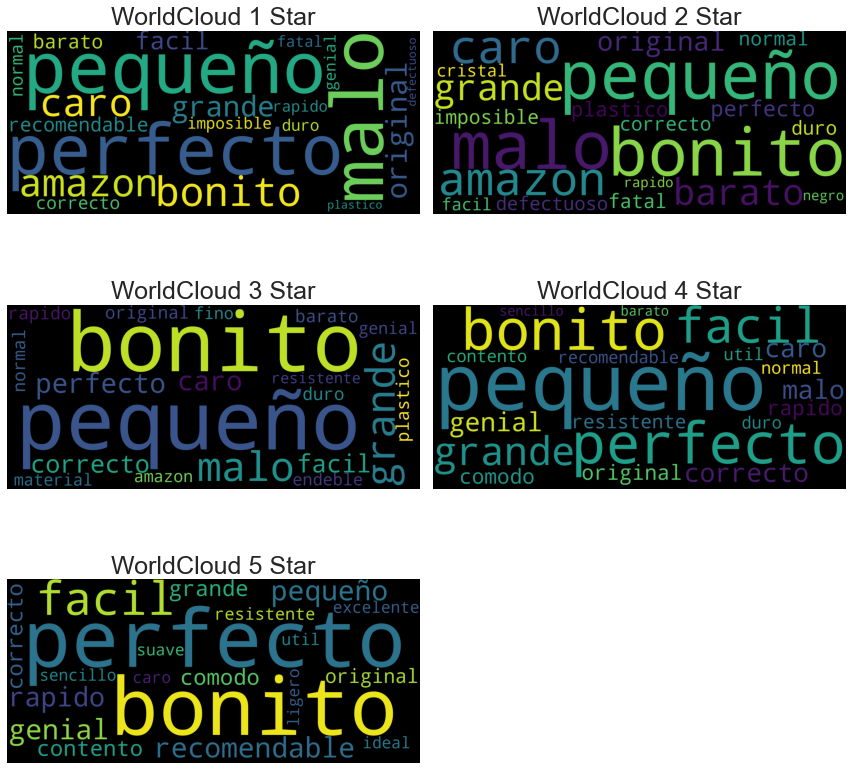

In [86]:
plt.figure(figsize=(12,12))

plt.subplot(321)
estrella1=(" ").join(words_star1["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800 ).generate(estrella1)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 1 Star', fontsize=25)

plt.subplot(322)
estrella2=(" ").join(words_star2["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella2)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 2 Star', fontsize=25)

plt.subplot(323)
estrella3=(" ").join(words_star3["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella3)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 3 Star', fontsize=25)

plt.subplot(324)
estrella4=(" ").join(words_star4["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella4)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 4 Star', fontsize=25)

plt.subplot(325)
estrella5=(" ").join(words_star5["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella5)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 5 Star', fontsize=25)

plt.tight_layout()
plt.show()

### *Los Estudios indican que las criticas negativas normalmente incluyen mas palabras que las positivas* 
**Por esta razon vamos a efectuar el siguiente analisis**

**Review_title**

In [87]:
data['contara_title'] = data["review_title"].apply(lambda x: len(str(x).split()))
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,malo comprar,malisimo grande aparatoso y protector pantalla,[malo],[grande],2
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,recibir,recibir pedir devolución,[],[],4
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,apretar manillar,buscar sistema funcionar abrazadera agarrar ma...,[],[abajar],7
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,broca mantequilla,utilizar broca menor diametro y doblar ser man...,[],"[menor, minima, amarillo, interior, gris]",3
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,gustar,gustar olor a viejo y aspecto malo,[],"[viejo, malo]",3


**Review_body**

In [88]:
data['contara_body'] = data["review_body"].apply(lambda x: len(str(x).split()))
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,malo comprar,malisimo grande aparatoso y protector pantalla,[malo],[grande],2,10
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,recibir,recibir pedir devolución,[],[],4,8
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,apretar manillar,buscar sistema funcionar abrazadera agarrar ma...,[],[abajar],7,28
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,broca mantequilla,utilizar broca menor diametro y doblar ser man...,[],"[menor, minima, amarillo, interior, gris]",3,52
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,gustar,gustar olor a viejo y aspecto malo,[],"[viejo, malo]",3,10


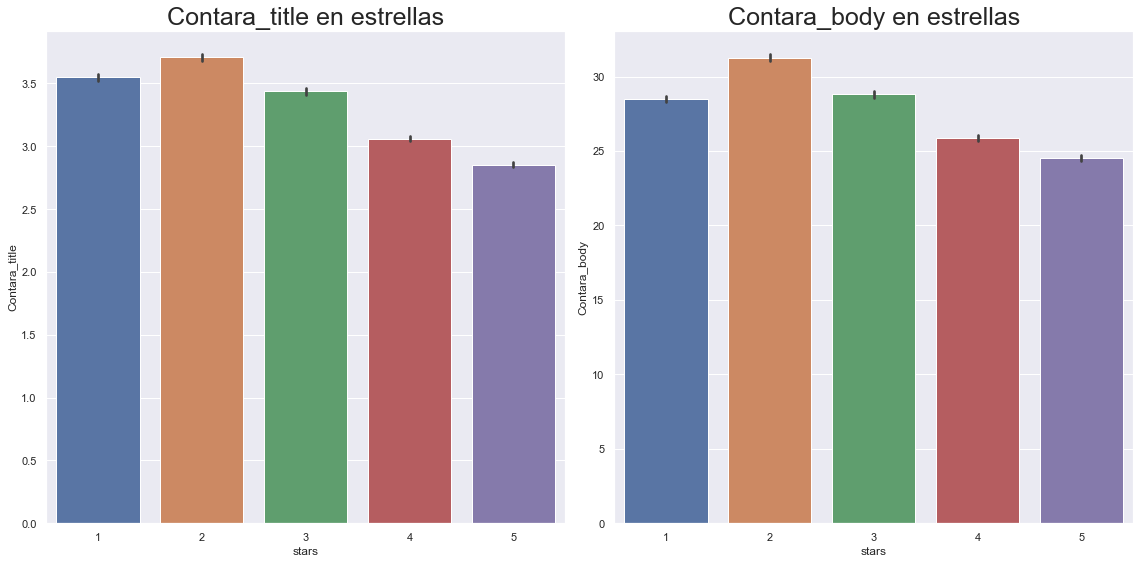

In [89]:
plt.figure(figsize=(16,8))

plt.subplot(121)
sns.barplot(data = data, x = "stars", y = "contara_title")
plt.title('Contara_title en estrellas', fontsize= 25)
plt.xlabel('stars')
plt.ylabel('Contara_title')

plt.subplot(122)
sns.barplot(data = data, x = "stars", y = "contara_body")
plt.title('Contara_body en estrellas', fontsize= 25)
plt.xlabel('stars')
plt.ylabel('Contara_body')

plt.tight_layout()
plt.show()

***Efectivamente de acuerdo a los resultados nos estan indicando  que las reseñas negativas tienen mas palabras que las positivas, posiblemente porque cuando nos sentimos satisfechos con algo pasa desapercibido y no tenemos nada que decir, no obstante, cuando estamos inconformes con algo generea malestar ocasionando que nos esforcemos mas en escribir o emitir calificaciones referente al producto.***

In [90]:
gc.collect

<function gc.collect(generation=2)>

**Limpieza de NA**

In [91]:
data.isna().sum()

stars                   0
review_body             0
review_title            0
product_category        0
New_R_title_Lemm        0
New_R_body_Lemm         0
New_R_title_Lemm_ADJ    0
New_R_body_Lemm_ADJ     0
contara_title           0
contara_body            0
dtype: int64

In [92]:
data.dropna(inplace=True)

In [93]:
data.describe()

,stars,contara_title,contara_body
count,210000.000000,210000.000000,210000.000000
mean,3.000000,3.321190,27.795571
std,1.414217,2.519907,24.153501
min,1.000000,1.000000,2.000000
25%,2.000000,2.000000,13.000000
50%,3.000000,3.000000,22.000000
75%,4.000000,4.000000,34.000000
max,5.000000,28.000000,551.000000


#### 2.  *Evalúa de forma apropiada sus resultados. Justifica la métrica elegida*

Para evaluar los resultados se trabajara con Accuracy debido a que el dataset se encuentra perfectamente balanceado, esto, teniendo en cuenta que cada estrella representa un 20% del dataset de acuerdo nuestro analisis previo.

####  3.  *Elige un modelo benchmark y compara tus resultados con este modelo.*

El Benchmark utilizado es GaussianNB debido a que Naive Bayes suele ser uno de los mejores modelos para NLP.

**Para la primera prueba solo trabajaremos con lemms**

In [94]:
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,malo comprar,malisimo grande aparatoso y protector pantalla,[malo],[grande],2,10
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,recibir,recibir pedir devolución,[],[],4,8
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,apretar manillar,buscar sistema funcionar abrazadera agarrar ma...,[],[abajar],7,28
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,broca mantequilla,utilizar broca menor diametro y doblar ser man...,[],"[menor, minima, amarillo, interior, gris]",3,52
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,gustar,gustar olor a viejo y aspecto malo,[],"[viejo, malo]",3,10


In [95]:
data_=data.copy()

In [96]:
data_['review_Final'] = data_['New_R_title_Lemm'] + ' ' + data_['New_R_body_Lemm']
data_.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body,review_Final
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,malo comprar,malisimo grande aparatoso y protector pantalla,[malo],[grande],2,10,malo comprar malisimo grande aparatoso y prote...
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,recibir,recibir pedir devolución,[],[],4,8,recibir recibir pedir devolución
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,apretar manillar,buscar sistema funcionar abrazadera agarrar ma...,[],[abajar],7,28,apretar manillar buscar sistema funcionar abra...
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,broca mantequilla,utilizar broca menor diametro y doblar ser man...,[],"[menor, minima, amarillo, interior, gris]",3,52,broca mantequilla utilizar broca menor diametr...
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,gustar,gustar olor a viejo y aspecto malo,[],"[viejo, malo]",3,10,gustar gustar olor a viejo y aspecto malo


In [97]:
%%time

def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

tokeandstp=[]
regexp=RegexpTokenizer(r"\w+")
data_['New_R_final_Lemm'] = ''

for i in range(data_.shape[0]):
    review = data_.iloc[i].review_Final
    review = regexp.tokenize(review) 
    review = [word.lower() for word in review if word.lower() not in STOP_WORDS]
    review = spell_check(review)
    review = nlp(review)
    review = [word.lemma_ for word in review]
    data_['New_R_final_Lemm'].iloc[i] = ' '.join(review)

C:\Users\Claud\miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 33min 29s


In [98]:
list_revs = list(data_['New_R_final_Lemm'].values)
stars_ = data_["stars"].values

In [99]:
type(list_revs)

list

In [100]:
tfidf = TfidfVectorizer(max_features=1000,lowercase=False)

In [101]:
matriz_revs = tfidf.fit_transform(list_revs)

# Tomamos las palabras
all_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['10', '100', '12', '15', '20', '24', '30', '40', '50', 'abajar', 'abotonar', 'abrir', 'abrirlo', 'absoluto', 'acabar', 'accesorio', 'aceitar', 'aceptable', 'acerar', 'acertar', 'acolchar', 'aconsejar', 'acoplar', 'acorde', 'acostumbrar', 'activar', 'adaptador', 'adaptar', 'adecuar', 'adherir', 'adhesivo', 'adquirir', 'adulto', 'agarrar', 'agradable', 'aguantar', 'aguar', 'agujerar', 'agujerear', 'ahorrar', 'aire', 'ajustar', 'alcanzar', 'alguien', 'algun', 'altavoz', 'alto', 'altura', 'alumbrar', 'amarillo']


**Modelado**

Train_Test_Split

In [102]:
x = matriz_revs.toarray()
y = stars_


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

**Funcion para ver Confusion**

In [103]:
def confusion(y_test,y_test_pred,X):
    names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(8,8))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

**NB (Benchmark)**

In [104]:
nb = GaussianNB()
nb.fit(X_train,y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train GaussianNB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test GaussianNB: ", accuracy_score(y_test, y_test_pred))

Accuracy train GaussianNB:  0.37800680272108844
Accuracy test GaussianNB:  0.36153968253968255


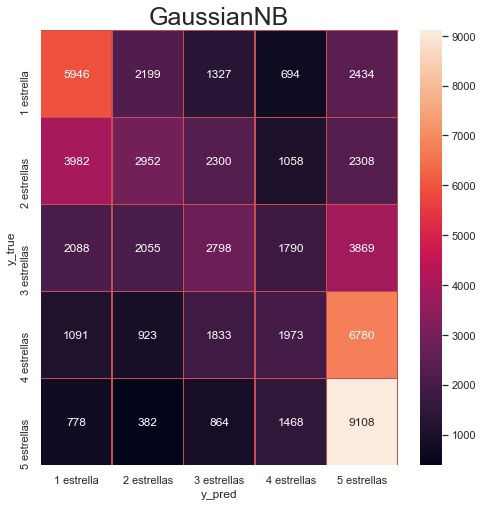

In [105]:
confusion(y_test,y_test_pred,"GaussianNB")

In [106]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.43      0.47      0.45     12600
           2       0.35      0.23      0.28     12600
           3       0.31      0.22      0.26     12600
           4       0.28      0.16      0.20     12600
           5       0.37      0.72      0.49     12600

    accuracy                           0.36     63000
   macro avg       0.35      0.36      0.34     63000
weighted avg       0.35      0.36      0.34     63000



**LinearSVC**

In [107]:
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.43976190476190474
Accuracy test LinearSVC:  0.4212063492063492


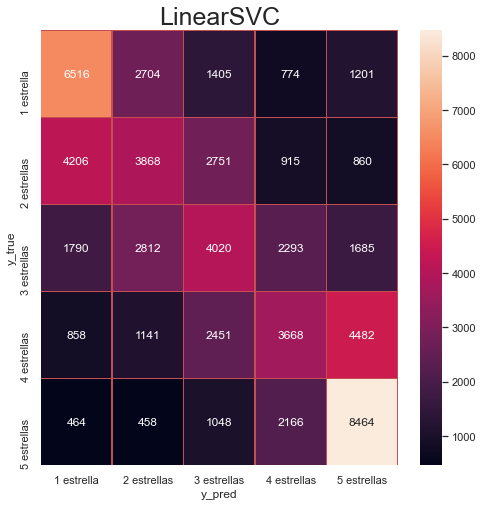

In [108]:
confusion(y_test,y_test_pred,"LinearSVC")

In [109]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.47      0.52      0.49     12600
           2       0.35      0.31      0.33     12600
           3       0.34      0.32      0.33     12600
           4       0.37      0.29      0.33     12600
           5       0.51      0.67      0.58     12600

    accuracy                           0.42     63000
   macro avg       0.41      0.42      0.41     63000
weighted avg       0.41      0.42      0.41     63000



### 4. *Optimiza los hiperparámetros de tu modelo*

Se utiliza GridSearchCV para la optimizacion del LinerarSVC. Solo se trabajara con C.

**LinearSVC Optimizado con Gridsearch**

In [110]:
param_grid = {'C': [0.1,1,3,6] }  
  
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3,n_jobs=-1) 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=LinearSVC(C=1), n_jobs=-1,
             param_grid={'C': [0.1, 1, 3, 6]}, verbose=3)

In [111]:
print(grid.best_estimator_)

LinearSVC(C=0.1)


In [112]:
print(grid.best_params_)

{'C': 0.1}


In [113]:
svc = LinearSVC(C = 0.1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.439578231292517
Accuracy test LinearSVC:  0.42173015873015873


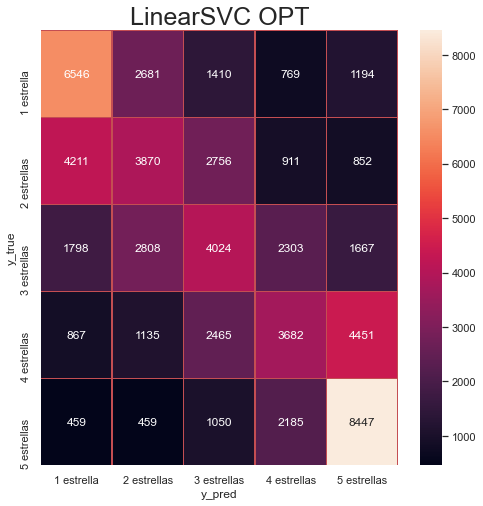

In [114]:
confusion(y_test,y_test_pred,"LinearSVC OPT")

In [115]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.47      0.52      0.49     12600
           2       0.35      0.31      0.33     12600
           3       0.34      0.32      0.33     12600
           4       0.37      0.29      0.33     12600
           5       0.51      0.67      0.58     12600

    accuracy                           0.42     63000
   macro avg       0.41      0.42      0.41     63000
weighted avg       0.41      0.42      0.41     63000



In [116]:
gc.collect

<function gc.collect(generation=2)>

### 5. *Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?*

A continuacion se presentan las palabras que utiliza el LinearSVC para predecir.

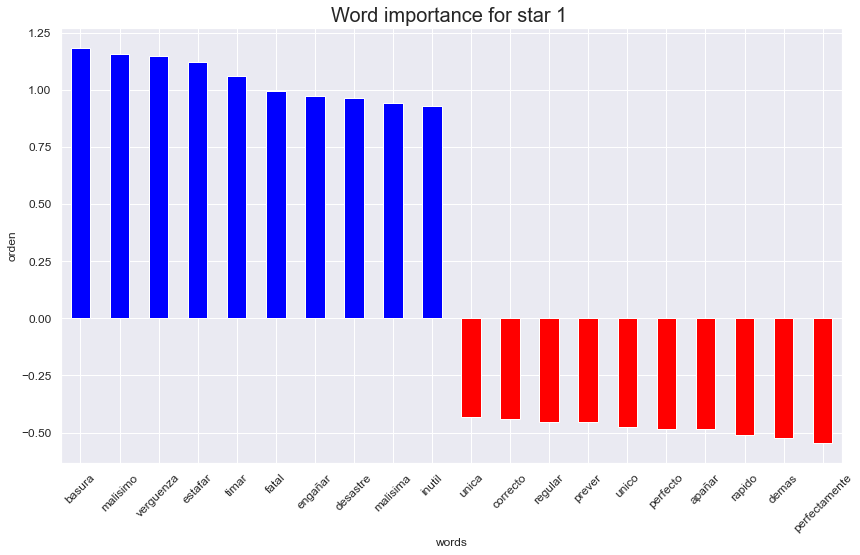

In [117]:
coeff = list(svc.coef_[0])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 1 ',fontsize=20)
plt.show()

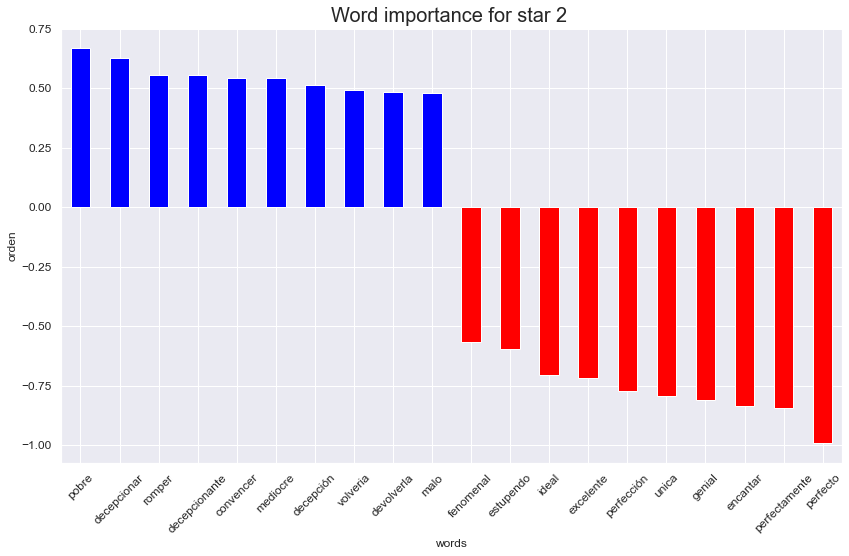

In [118]:
coeff = list(svc.coef_[1])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 2 ',fontsize=20)
plt.show()

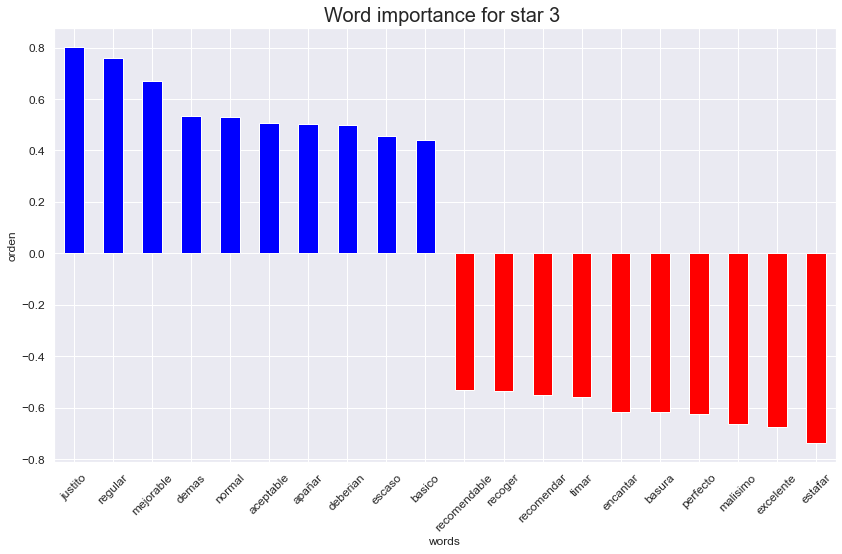

In [119]:
coeff = list(svc.coef_[2])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 3 ',fontsize=20)
plt.show()

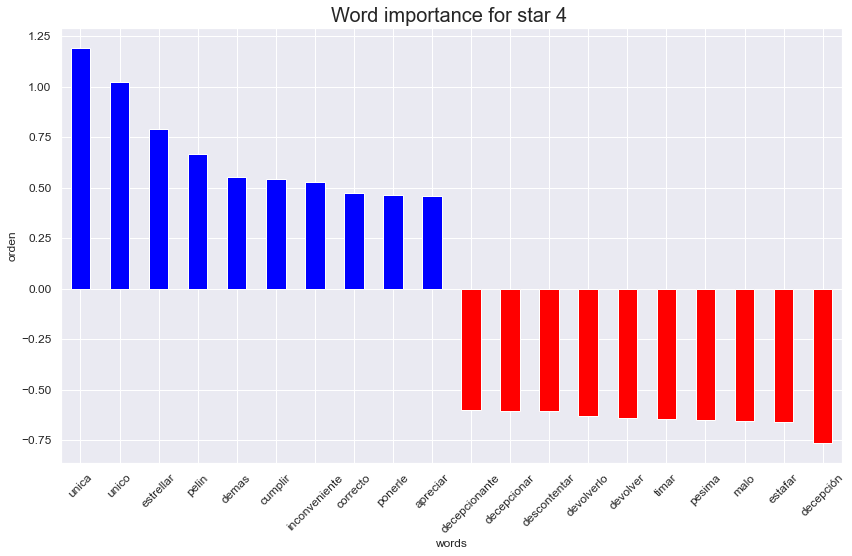

In [120]:
coeff = list(svc.coef_[3])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 4 ',fontsize=20)
plt.show()

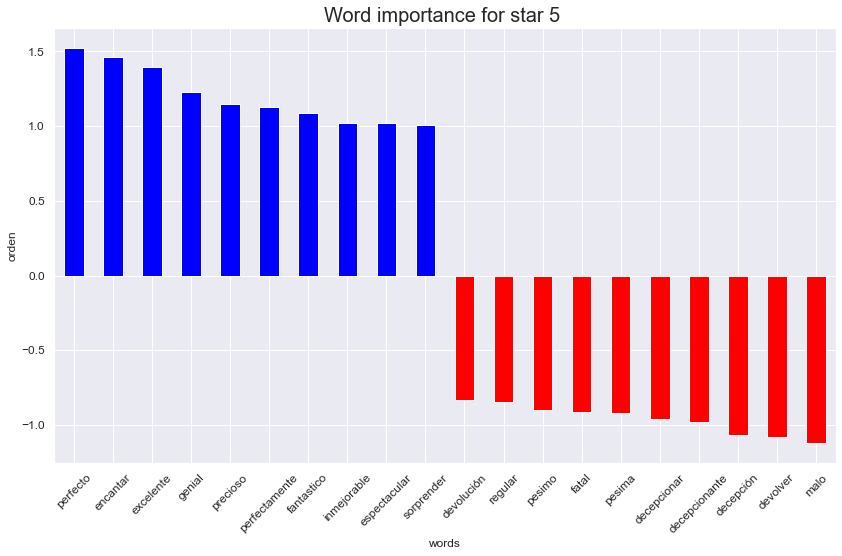

In [121]:
coeff = list(svc.coef_[4])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 5 ',fontsize=20)
plt.show()

### Para pensar, investigar y, opcionalmente, implementar

***¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?***

*El resultado logrado con el modelo binario fue exitoso, estos modelos lograron mejorar la clasificacion de una manera mas eficiente; es de resaltar que si revisamos el punto de vista del usuario al  realizar puntuaciones con Positivo y/o Negativo en lugar del uso de estrellas facilitaria la toma de decisiones y se podria manejar un modelo predictivo basado en esta etiqueta,este clasificador de análisis de sentimiento simple podria ser muy útil. Es importante resaltar que  no se implementara en este proyecto con el fin de poderlo desarrollar en el cuarto proyecto de la carrera.*

### Gracias!